In [2]:
import pandas as pd
import numpy as np
np.set_printoptions(precision = 3)

 Reading the data and droping the first column

In [3]:
myData = pd.read_csv("jester-data-1.csv" ,header=None)
myData = myData.drop(0,axis=1)
myData.shape

(24983, 100)

 it will Take long time to process all data so I will use only first 30 rows of the data set 

In [4]:
myData_Partial = myData.head(30)
myData_Partial.shape

(30, 100)

In [5]:
myData.head(3)

,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
0,-7.82,8.79,-9.66,-8.16,-7.52,-8.50,-9.85,4.17,-8.98,-4.76,...,2.82,99.00,99.00,99.00,99.00,99.00,-5.63,99.00,99.00,99.00
1,4.08,-0.29,6.36,4.37,-2.38,-9.66,-0.73,-5.34,8.88,9.22,...,2.82,-4.95,-0.29,7.86,-0.19,-2.14,3.06,0.34,-4.32,1.07
2,99.00,99.00,99.00,99.00,9.03,9.27,9.03,9.27,99.00,99.00,...,99.00,99.00,99.00,9.08,99.00,99.00,99.00,99.00,99.00,99.00


Initializing the hyperparameter 

In [22]:
alpha = 0.001
n_latent = 2
n_iterations = 30
n_Folds=10

initializing the latent arrays 

In [23]:
latent_users = np.random.random((myData_Partial.shape[0], n_latent))
latent_items = np.random.random((myData_Partial.shape[1], n_latent))

getting not nan indeies 

In [24]:
not_Nan_Inds = np.argwhere(np.not_equal(myData_Partial.values,99.0))
np.random.shuffle(not_Nan_Inds)
not_Nan_Inds.shape

(2167, 2)

Splitting the not nan indecies into n folds

In [25]:
not_Nan_Inds_Splitted = np.array(np.array_split(not_Nan_Inds,n_Folds))
for i in not_Nan_Inds_Splitted:
    print(i.shape)

(217, 2)
(217, 2)
(217, 2)
(217, 2)
(217, 2)
(217, 2)
(217, 2)
(216, 2)
(216, 2)
(216, 2)


In [26]:
def predict_rating(user_id,item_id,latent_users,latent_items):
    """ Predict a rating given a user_id and an item_id.
    """
    user_preference = latent_users[user_id]
    item_preference = latent_items[item_id]
    return user_preference.dot(item_preference)

def train(user_id, item_id, rating,latent_users,latent_items,alpha = 0.0001):
    #print item_id
    prediction_rating = predict_rating(user_id, item_id,latent_users,latent_items)
    err =  ( prediction_rating- rating );
    #print err
    user_pref_values = latent_users[user_id][:]
    latent_users[user_id] -= alpha * err * latent_items[item_id]
    latent_items[item_id] -= alpha * err * user_pref_values
    return err,latent_users,latent_items


def test(foldNum):
    # this function is calculating the mean square error for the testing fold 
    MSE = 0;
    errs=[]
    for i,j in not_Nan_Inds_Splitted[foldNum]:
        err= myData.values[i][j] - predict_rating(i,j,latent_users,latent_items)
        errs.append(err)
    MSE = (np.array(errs) ** 2).mean()
    return MSE
        
    

def sgdKfolds():
    # 1-D array storing the testing mean square error for each fold
    TestingMSEs=[]
    # 2-D array storing the training mean square error for each fold and fold iteration 
    TrainingMSE=[]
    for foldsIteration in range(0,n_Folds):   # loop for all folds n fold times 
        #print("fold iteration ",foldsIteration)
        # resetting the latent arrays 
        latent_users = np.random.random((myData_Partial.shape[0], n_latent))
        latent_items = np.random.random((myData_Partial.shape[1], n_latent))
        iterationMSES = []
        for iteration in range(0,n_iterations): 
            currentFold=0  # this variable is an index. I used it for checking the test fold 
            iterationE=[]
            for IndArray in not_Nan_Inds_Splitted:
                if(currentFold == foldsIteration):   # check if this fold is the one which you mark as a testing fold Test for other folds
                    currentFold = currentFold+1  
                    continue
                currentFold = currentFold+1
                for i,j in IndArray:        
                    rating = myData_Partial.values[i][j]
                    e,latent_users,latent_items=train(i,j,rating,latent_users,latent_items,alpha)
                    iterationE.append(e)
            iterationMSE= (np.array(iterationE) ** 2).mean()
            #print("iteration ",iteration,"of fold number ",foldsIteration," has training error = ",iterationMSE)
            iterationMSES.append(iterationMSE)
        TrainingMSE.append(iterationMSES)
        mse = test(foldsIteration)
        TestingMSEs.append(mse)
        print("Testing MSE for folds iteration number ",foldsIteration + 1,"  = " , mse)
    AvgTestingError = np.mean(TestingMSEs)
    print("Avarage Testing mean square Error = ",AvgTestingError)
    return TestingMSEs,TrainingMSE,AvgTestingError
    

In [27]:
TestingMSE , TrainingMSE , Avg = sgdKfolds()

Testing MSE for folds iteration number  1   =  26.13430630109006
Testing MSE for folds iteration number  2   =  30.462281242897753
Testing MSE for folds iteration number  3   =  29.662435488444267
Testing MSE for folds iteration number  4   =  26.52210076863233
Testing MSE for folds iteration number  5   =  27.345815412860272
Testing MSE for folds iteration number  6   =  27.825894346487306
Testing MSE for folds iteration number  7   =  28.58649728497819
Testing MSE for folds iteration number  8   =  25.813323353122215
Testing MSE for folds iteration number  9   =  26.74836112906037
Testing MSE for folds iteration number  10   =  27.978753695134284
Avarage Testing mean square Error =  27.70797690227071


Plotting the testing error 

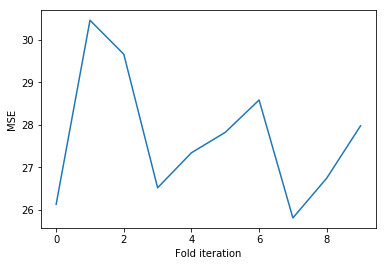

In [37]:
import matplotlib.pyplot as plt 
plt.plot(TestingMSE)
plt.xlabel("Fold iteration")
plt.ylabel("MSE")
plt.show()

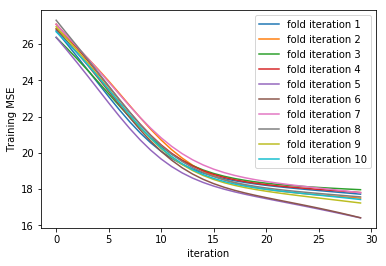

In [57]:
d="fold"
for i in range(0,n_Folds):
    plt.plot(TrainingMSE[i],label=("fold iteration " + str(i+1)))
plt.xlabel("iteration")
plt.ylabel("Training MSE")
plt.legend()
plt.show()